In [1]:
import os 
import pandas as pd

from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
from collections import Counter
import seaborn as sn
import random
import statistics 
import statsmodels.api as sm

import numpy as np

/home/joel/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
box_file_dir = os.path.join(os.getcwd(), "..", "..", "Box")
file_path_csv = os.path.join(box_file_dir, "covid_pts_enc_level_labs_dx_2021-02-02_deid.csv")

In [3]:
df = pd.read_csv(file_path_csv, index_col=False)

In [4]:
df.head()

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,...,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,...,False,False,False,False,False,False,NaN,4dMaH,61003,10650
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,...,False,False,False,False,False,False,3.0,8wQnr,84969,27818
2,2020-03-25 13:25:00,2020-03-30 03:48:00,Medical Center,IP Private/Semi Private room,80,Female,78758,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,...,True,False,True,True,True,False,1.0,6YGuu,69112,34412
3,2020-03-25 13:36:00,2020-03-27 13:15:00,Medical Center,IP Private/Semi Private room,56,Male,78746,Not Hispanic or Latino,White,White Non Hispanic,...,False,False,False,False,False,False,1.0,P1Tjg,84820,37981
4,2020-03-25 13:43:00,2020-03-27 12:44:00,Medical Center,IP Private/Semi Private room,46,Female,78757,Not Hispanic or Latino,White,White Non Hispanic,...,False,False,False,False,False,False,0.0,iouKO,76686,41152


In [5]:
def latinx(row):
    if row.ethnicity_display == 'Hispanic or Latino' and row.race_display == 'White':
        return "Hispanic"
    elif row.ethnicity_display == 'Not Hispanic or Latino' and row.race_display == 'White': 
        return "White"
    else:
        return row.race_display
        

In [6]:
df['race_display'] = df.apply(lambda row: latinx(row), axis=1)

In [7]:
vent_df = df[~df['vent_hours_summed'].isnull()]

In [8]:
len(vent_df)

303

In [9]:
Counter(vent_df['race_display'])

Counter({'Hispanic': 161,
         'White': 86,
         'Black or African American': 26,
         'Asian': 4,
         'Other Race': 12,
         'Unknown': 8,
         'Decline to Specify': 4,
         'American Indian/Alaska Native': 2})

In [10]:
icu_df = df[~df['icu_hours_summed'].isnull()]

In [11]:
Counter(icu_df['race_display'])

Counter({'Hispanic': 369,
         'White': 252,
         'Black or African American': 61,
         'Unknown': 16,
         'American Indian/Alaska Native': 4,
         'Asian': 7,
         'Other Race': 27,
         'Decline to Specify': 4,
         'Native Hawaiian or Other Pacific Islande': 1})

In [12]:
working_df = icu_df[~icu_df['qSOFA_score'].isnull()] 
Counter(working_df['race_display'])

Counter({'Hispanic': 357,
         'White': 242,
         'Black or African American': 59,
         'Unknown': 16,
         'American Indian/Alaska Native': 4,
         'Asian': 7,
         'Other Race': 26,
         'Decline to Specify': 4,
         'Native Hawaiian or Other Pacific Islande': 1})

In [13]:
data = icu_df[['age_at_admit', 'pO2_Art', 
               'qSOFA_score','race_display',
              'vent_hours_summed', 'zip_cust_table', 'heartfailure_com_flag',
              'cancer_com_flag','gender','WBC','Mean_Arterial_Pressure',
              'Bili_Total','CAD_com_flag','CKD_com_flag','COPD_com_flag',
 'Creatinine', 'FiO2/Percent','Glasgow_Coma_Score','diabetes_com_flag',
 'hypertension_com_flag','length_of_stay','discharge_disposition_display','Platelet', 'deid_empi_encounter']]

In [14]:
data.head()

,age_at_admit,pO2_Art,qSOFA_score,race_display,vent_hours_summed,zip_cust_table,heartfailure_com_flag,cancer_com_flag,gender,WBC,...,COPD_com_flag,Creatinine,FiO2/Percent,Glasgow_Coma_Score,diabetes_com_flag,hypertension_com_flag,length_of_stay,discharge_disposition_display,Platelet,deid_empi_encounter
0,49,NaN,NaN,Hispanic,NaN,Unknown,False,False,Male,NaN,...,False,1.1,NaN,NaN,False,False,6.75,Home,NaN,4dMaH
1,44,470.8,3.0,Hispanic,58.45,78130,False,False,Male,35.1,...,False,2.9,50.0,3.0,False,False,2.75,Expired,42.0,8wQnr
6,49,250.1,1.0,White,293.02,78612,False,False,Female,12.1,...,False,0.9,100.0,15.0,False,False,12.92,Home,355.0,P9yRo
11,24,56.4,2.0,White,1423.18,78753,False,False,Male,19.4,...,False,1.5,80.0,3.0,False,False,64.88,Long Term Care Hospital,370.0,23f5M
17,55,102.6,0.0,White,327.77,78602,False,False,Male,4.6,...,False,1.2,100.0,15.0,False,True,17.13,Expired,199.0,mNyVy


In [15]:
working_df[['race_display', 'age_at_admit']].groupby('race_display').agg(['mean', 'count'])

age_at_admit      
                                                 mean count
race_display                                               
American Indian/Alaska Native               34.000000     4
Asian                                       50.714286     7
Black or African American                   62.186441    59
Decline to Specify                          53.250000     4
Hispanic                                    56.929972   357
Native Hawaiian or Other Pacific Islande    41.000000     1
Other Race                                  51.461538    26
Unknown                                     67.000000    16
White                                       59.913223   242

In [16]:
# only 236 patients with all tests
allo_df = data[['pO2_Art', 'Creatinine', 'FiO2/Percent', 
      'Glasgow_Coma_Score', 'Platelet', 'Mean_Arterial_Pressure',
     'Bili_Total', 'deid_empi_encounter']].dropna()

In [17]:
list_of_patients = list(allo_df['deid_empi_encounter'])

In [18]:
adjusted_patients = data[data['deid_empi_encounter'].isin(list_of_patients)]

In [19]:
def calculate_sofa(row):
    count = 0
    
    # need to implement Fi02/po2
    
    if row.Platelet >= 100 and row.Platelet <= 149:
        count += 1 
        
    elif row.Platelet >= 50 and row.Platelet <= 99:
        count += 2
        
    elif row.Platelet >= 20 and row.Platelet <= 49:
        count += 3
        
    elif row.Platelet < 20:
        count += 4
       
    # Glasgow
    if row.Glasgow_Coma_Score == 13 or row.Glasgow_Coma_Score == 14:
        count += 1 
        
    elif row.Glasgow_Coma_Score >= 10 and row.Glasgow_Coma_Score <= 12:
        count += 2
        
    elif row.Glasgow_Coma_Score >= 6 and row.Glasgow_Coma_Score <= 9:
        count += 3
        
    elif row.Glasgow_Coma_Score < 6:
        count += 4
        
    # Bilirubin 
    
    if float(row.Bili_Total) >= 1.2 and float(row.Bili_Total) <= 1.9:
        count += 1 
        
    elif float(row.Bili_Total) >= 2.0 and float(row.Bili_Total) <= 5.9:
        count += 2
        
    elif float(row.Bili_Total) >= 6.0 and float(row.Bili_Total) <= 11.9:
        count += 3
        
    elif float(row.Bili_Total) >= 12.0:
        count += 4 
        
    # Need to implement Mean artieral pressure later 
    
    # Creatinine 
    
    if row.Creatinine >= 1.2 and row.Creatinine <= 1.9:
        count += 1 
        
    elif row.Creatinine >= 2.0 and row.Creatinine <= 3.4:
        count += 2
        
    elif row.Creatinine >= 3.5 and row.Creatinine <= 4.9:
        count += 3
        
    elif row.Creatinine >= 5.0:
        count += 4 
        
    return count 

In [20]:
allo_df['sofa'] = allo_df.apply(lambda row: calculate_sofa(row), axis = 1)

In [21]:
adjusted_patients['sofa'] = allo_df.apply(lambda row: calculate_sofa(row), axis = 1)

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
allo_df['sofa'].describe()

count    236.000000
mean       1.716102
std        1.982883
min        0.000000
25%        0.000000
50%        1.000000
75%        2.250000
max       11.000000
Name: sofa, dtype: float64

In [23]:
adjusted_patients['sofa'].describe()

count    236.000000
mean       1.716102
std        1.982883
min        0.000000
25%        0.000000
50%        1.000000
75%        2.250000
max       11.000000
Name: sofa, dtype: float64

In [24]:
#https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence
sofa_mortality_calibration = {
    0: 0,
    1: 0 ,
    2: 6.4,
    3: 6.4,
    4: 20.2,
    5: 20.2,
    6: 21.5,
    7: 21.5,
    8: 33.3,
    9: 33.3 ,
    10: 50.0,
    11: 50.0 ,
    12: 95.2,
    13: 95.2 ,
    14: 95.2  , 
    
}

In [25]:
# still need to check corrobate 
# digging onto various studies on measuring qSOFA for different comorbidities 
# Min linked a paper about influenza 
# can use these values 

qsofa_mortality_calibration = {
    0: 0.6,
    1: 5 ,
    2: 10,
    3: 24,
    
}

In [26]:
working_df.dtypes

admit_dt_tm                object
discharge_dt_tm            object
facility                   object
encounter_type_display     object
age_at_admit                int64
                           ...   
cancer_com_flag            object
qSOFA_score               float64
deid_empi_encounter        object
deid_mrn_encounter          int64
deid_fin_encounter          int64
Length: 70, dtype: object

In [27]:
def comorbidity_count(row):
    count = 0 
    
    if row.COPD_com_flag == 1:
        count += 1 
        
    if row.asthma_com_flag == 1:
        count += 1 
        
    if row.diabetes_com_flag == 1:
        count += 1 
        
    if row.hypertension_com_flag == 1:
        count += 1 
        
    if row.CAD_com_flag == 1:
        count += 1 
        
    if row.heartfailure_com_flag == 1: 
        count += 1 
        
    if row.CKD_com_flag == 1:
        count += 1 
        
    if row.cancer_com_flag == 1:
        count += 1 
        
    return count

In [28]:
working_df[['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
       'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
       'CKD_com_flag', 'cancer_com_flag']] = working_df[['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
       'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
       'CKD_com_flag', 'cancer_com_flag']].fillna(0)

/home/joel/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [29]:
working_df[['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
       'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
       'CKD_com_flag', 'cancer_com_flag']] = working_df[['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
       'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
       'CKD_com_flag', 'cancer_com_flag']].astype(int)

In [30]:
working_df['total_comorbidities'] = working_df.apply(lambda row: comorbidity_count(row), axis=1)

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
working_df['cancer_com_flag'].dtype

dtype('int64')

In [32]:
working_df['has_comorbidity'] = working_df.total_comorbidities.apply(lambda x: 1 if x >= 1 else 0)

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
working_df['has_comorbidity2'] = working_df.total_comorbidities.apply(lambda x: 1 if x >= 2 else 0)

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
working_df['life_years'] = working_df.age_at_admit.apply(lambda x: 100 - x)

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
Counter(adjusted_patients['discharge_disposition_display'])

Counter({'Home': 67,
         'Expired': 78,
         'Home Care with Home Health': 19,
         'Rehab Care': 8,
         'Another Hospital': 9,
         'Long Term Care Hospital': 30,
         'Skilled Nursing Care': 21,
         'Still a patient': 7,
         'Home Hospice Care': 1,
         nan: 4,
         'Hospice Facility': 1})

In [36]:
class Allocation(object):
    # Code will be adjusted for SOFA. Currently using qSOFA 
    # Only looking at State Level CSC for vent allocation 
    def __init__(self, patients, scarcity, sofa_calibration):
        self.patients = patients.copy() 
        self.patients['death'] = [0 for _ in range(len(self.patients))]
        self.patients['allocated_vent'] = ["no" for _ in range(len(self.patients))]
        
        self.num_vents = int(len(patients) * scarcity) 
        
        self.mortality_model = sofa_calibration
        
    def allocate(self, row):
        prob = self.mortality_model[row.qSOFA_score]
    
        
        death = np.random.binomial(size=1, n=1, p=prob*.01)[0]
        #print(death)
        
        if death == 1 or row.discharge_disposition_display == 'Expired':
            return death, 'yes'
        
        else:
            #print('yup yup')
            return death, 'yes'
    
    def check_expiration(self, df):

        temp_df = df.copy()
        for i, row in df.iterrows():
            row = row.copy()
            if (pd.isna(row.vent_hours_summed)) or row.discharge_disposition_display == 'Expired':
        
                temp_df.loc[i, 'death'] = 1

            else:
                
                temp_df.loc[i, 'death'] = 0
                
                
        return temp_df
    
    def __run_allocation(self, df2):
        
        for i, row in df2.iterrows():
            row = row.copy()
            if self.num_vents == 0:
                #print('out')
                break
            
            mortality, allocate_cond = self.allocate(row)
            
            df2.loc[i, 'death'] = mortality
                
            df2.loc[i, 'allocated_vent'] = allocate_cond
            
            self.num_vents -= 1 
        
        non_allocated = df2[df2['allocated_vent']=='no']
        allocated = df2[df2['allocated_vent']=='yes']
        
        adj_df = self.check_expiration(non_allocated)
        
        return pd.concat([allocated, adj_df])
        
                    
    def lottery(self):
        temp_patients = self.patients.copy()
        
        temp_patients.sample(frac=1)
        
        out_df = self.__run_allocation(temp_patients)
        return out_df 
    
    def youngest(self):
        temp_patients = self.patients.copy()
        
        temp_patients.sort_values(by=['age_at_admit'], ascending=True, inplace=True)
        
        out_df = self.__run_allocation(temp_patients)
        return out_df 
    
    # pandas function
    def __age_categorization(self, row):
        if row.age_at_admit < 50:
            return 1 
        elif row.age_at_admit < 70: 
            return 2 
        elif row.age_at_admit < 85:
            return 3 
        else:
            return 4
        
            
        
    def maryland(self):
        temp_patients = self.patients.copy()
        temp_patients['age_cat'] = temp_patients.apply(lambda row: self.__age_categorization(row)
                                                       , axis=1)
        
        temp_patients.sort_values(by=['qSOFA_score', 'total_comorbidities', 'age_cat'], 
                                      ascending=[True, True, True], inplace=True)
        
        out_df = self.__run_allocation(temp_patients)
        return out_df 
            
    def new_york(self):
        temp_patients = self.patients.copy()

        groups = [df for _, df in temp_patients.groupby('qSOFA_score')]
        random.shuffle(groups)

        grouped = pd.concat(groups).reset_index(drop=True)
        grouped = grouped.sort_values('qSOFA_score', ascending=True)
        
        out_df = self.__run_allocation(grouped)
        return out_df 
            
    
    def max_lives_saved(self):
        temp_patients = self.patients.copy()
        
        temp_patients.sort_values(by=['qSOFA_score'], ascending=True, inplace=True)
        
        out_df = self.__run_allocation(temp_patients)
        return out_df 
    
    def max_life_years(self):
        temp_patients = self.patients.copy()

        temp_patients.sort_values(by=['qSOFA_score', 'life_years'], ascending=[True,False], inplace=True)

        out_df = self.__run_allocation(temp_patients)
        return out_df 
        
    def sickest_first(self):
        temp_patients = self.patients.copy()
        
        temp_patients.sort_values(by=['qSOFA_score'], ascending=False, inplace=True)
        
        out_df = self.__run_allocation(temp_patients)
        return out_df 
        

In [37]:
zip_df = pd.read_csv('zip_code_data.csv', index_col=False)
zip_df['zip_code'] = zip_df.zip_code.apply(lambda x: x.strip('ZCTA5 '))

In [38]:
working_df = pd.merge(working_df, zip_df, left_on='zip_cust_table', right_on='zip_code', how='inner')

### Baseline

In [39]:
Counter(working_df['discharge_disposition_display'])

Counter({'Expired': 148,
         'Rehab Care': 19,
         'Skilled Nursing Care': 50,
         'Still a patient': 12,
         'Home': 280,
         'Long Term Care Hospital': 50,
         'Home Care with Home Health': 48,
         'Another Hospital': 12,
         nan: 14,
         'Home Hospice Care': 6,
         'Hospice Facility': 4,
         'Court/Law Enforcement': 1,
         'Intermediate Care': 4,
         'Psychiatric Hospital': 1,
         'Against Medical Advice': 3})

In [40]:
def latinx(row):
    if row.ethnicity_display == 'Hispanic or Latino' and row.race_display == 'White':
        return "Hispanic"
    elif row.ethnicity_display == 'Not Hispanic or Latino' and row.race_display == 'White': 
        return "White"
    else:
        return row.race_display

In [41]:
working_df['race_display'] = df.apply(lambda row: latinx(row), axis=1)

In [42]:
# later think about the mortality rate as well 
# summarize what I'm going to do and send to Victoria 

In [43]:
len(working_df)

652

In [44]:
# compute other descriptive stats for this groupby 
# final analysis 
working_df[['race_display', 'age_at_admit']].groupby('race_display').agg(['mean', 'std', 'count']).round(2)

age_at_admit             
                                      mean    std count
race_display                                           
American Indian/Alaska Native        59.67  12.74     3
Asian                                59.14  20.31     7
Black or African American            61.68  16.85    65
Decline to Specify                   57.22  17.90     9
Hispanic                             57.51  17.36   309
Other Race                           58.46  21.00    37
Unknown                              55.21  18.16    24
White                                56.75  17.45   198

In [45]:
Counter(working_df['qSOFA_score'])

Counter({3.0: 14, 2.0: 99, 1.0: 363, 0.0: 176})

In [46]:
len(working_df['zip_cust_table'].unique())

97

In [47]:
# zip code demo eda 
c = Counter(working_df['zip_cust_table'])
alist = c.most_common()
sum_patient = list(filter(lambda x: x[0][2] == '7', alist))

print(len(sum_patient))
num_p = 0 
for x in sum_patient:
    num_p += x[1]
    
num_p

37


327

In [48]:
c = Counter(working_df['zip_cust_table'])
alist = c.most_common()
n_alist = list(filter(lambda x: x[1] > 1, alist))
print(len(n_alist))
#n_alist

60


/home/joel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='qSOFA_score', ylabel='Density'>

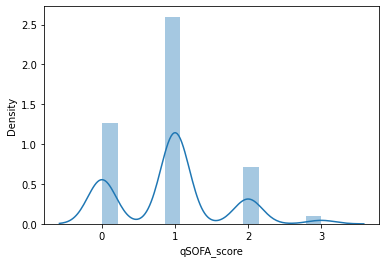

In [49]:
sn.distplot(working_df['qSOFA_score'])

In [50]:
race_count = Counter(working_df['race_display'])
race_count

Counter({'Hispanic': 309,
         'Black or African American': 65,
         'White': 198,
         'Asian': 7,
         'Unknown': 24,
         'Other Race': 37,
         'American Indian/Alaska Native': 3,
         'Decline to Specify': 9})

In [51]:
working_df['poverty_rate'] = working_df['poverty_rate'].astype(float)
working_df['median_income'] = working_df['median_income'].astype(float)

In [52]:
bins = [0, 6, 12, 18,24,30,36,40]
bin_conv = [i+1 for i in range(len(bins))]
working_df['zip_binned_by_poverty'] = np.searchsorted(bins, working_df['poverty_rate'].values)
#temp_df['zip_binned_by_poverty'] = np.searchsorted(bins, temp_df['poverty_rate'].values)

In [53]:
bins = [20000, 40000, 60000, 80000,100000]
bin_conv = [i+1 for i in range(len(bins))]
working_df['zip_binned_by_income'] = np.searchsorted(bins, working_df['median_income'].values)

In [54]:
working_df['death'] = working_df.discharge_disposition_display.apply(lambda row: 1 if row == 'Expired' else 0)

In [55]:
Counter(working_df['death'])

Counter({1: 148, 0: 504})

In [56]:
data_for_model_X = working_df[['zip_binned_by_income', 
                             'zip_binned_by_poverty', 
                            'race_display',
                            'total_comorbidities', 
                            'has_comorbidity',
                            'has_comorbidity2',
                            'age_at_admit', 
                            'qSOFA_score', 
                            ]]
updated_data_for_model_X = pd.get_dummies(data_for_model_X)
data_for_model_y = working_df['death']

In [57]:
data_for_model_X.dtypes

zip_binned_by_income       int64
zip_binned_by_poverty      int64
race_display              object
total_comorbidities        int64
has_comorbidity            int64
has_comorbidity2           int64
age_at_admit               int64
qSOFA_score              float64
dtype: object

In [58]:
log_reg = sm.Logit(data_for_model_y, updated_data_for_model_X).fit()

         Current function value: 0.456956
         Iterations: 35


/home/joel/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [59]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  652
Model:                          Logit   Df Residuals:                      637
Method:                           MLE   Df Model:                           14
Date:                Tue, 04 May 2021   Pseudo R-squ.:                  0.1469
Time:                        15:46:59   Log-Likelihood:                -297.94
converged:                      False   LL-Null:                       -349.22
Covariance Type:            nonrobust   LLR p-value:                 1.519e-15
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
zip_binned_by_income                          -0.1587      0.164     -0.970      0.332      -0.479       0.162
zip_binned_by_poverty              

In [60]:
for table in log_reg.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &      death       & \textbf{  No. Observations:  } &      652   \\
\textbf{Model:}           &      Logit       & \textbf{  Df Residuals:      } &      637   \\
\textbf{Method:}          &       MLE        & \textbf{  Df Model:          } &       14   \\
\textbf{Date:}            & Tue, 04 May 2021 & \textbf{  Pseudo R-squ.:     } &   0.1469   \\
\textbf{Time:}            &     15:46:59     & \textbf{  Log-Likelihood:    } &   -297.94  \\
\textbf{converged:}       &      False       & \textbf{  LL-Null:           } &   -349.22  \\
\textbf{Covariance Type:} &    nonrobust     & \textbf{  LLR p-value:       } & 1.519e-15  \\
\bottomrule
\end{tabular}
%\caption{Logit Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                                                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule

In [69]:
params = log_reg.params
conf = log_reg.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                                                  5%       95%    Odds Ratio
zip_binned_by_income                        0.619255  1.175702  8.532643e-01
zip_binned_by_poverty                       0.734656  1.242609  9.554528e-01
total_comorbidities                         0.756419  1.369123  1.017660e+00
has_comorbidity                             0.748006  3.639985  1.650070e+00
has_comorbidity2                            0.650263  2.552781  1.288402e+00
age_at_admit                                1.032313  1.061950  1.047026e+00
qSOFA_score                                 1.296882  2.286150  1.721879e+00
race_display_American Indian/Alaska Native  0.000000       inf  1.766573e-14
race_display_Asian                          0.002248  0.325027  2.703084e-02
race_display_Black or African American      0.001468  0.066494  9.879973e-03
race_display_Decline to Specify             0.000000       inf  5.052744e-11
race_display_Hispanic                       0.001610  0.060471  9.866908e-03

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [70]:
conf[['5%', '95%', 'Odds Ratio' ]] = np.exp(conf[['5%', '95%', 'Odds Ratio']])
conf 

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


,5%,95%,Odds Ratio
zip_binned_by_income,0.619255,1.175702,8.532643e-01
zip_binned_by_poverty,0.734656,1.242609,9.554528e-01
total_comorbidities,0.756419,1.369123,1.017660e+00
has_comorbidity,0.748006,3.639985,1.650070e+00
has_comorbidity2,0.650263,2.552781,1.288402e+00
age_at_admit,1.032313,1.061950,1.047026e+00
qSOFA_score,1.296882,2.286150,1.721879e+00
race_display_American Indian/Alaska Native,0.000000,inf,1.766573e-14
race_display_Asian,0.002248,0.325027,2.703084e-02
race_display_Black or African American,0.001468,0.066494,9.879973e-03


In [71]:
print(conf.round(2).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &    5\% &   95\% &  Odds Ratio \\
\midrule
zip\_binned\_by\_income                       &  0.62 &  1.18 &        0.85 \\
zip\_binned\_by\_poverty                      &  0.73 &  1.24 &        0.96 \\
total\_comorbidities                        &  0.76 &  1.37 &        1.02 \\
has\_comorbidity                            &  0.75 &  3.64 &        1.65 \\
has\_comorbidity2                           &  0.65 &  2.55 &        1.29 \\
age\_at\_admit                               &  1.03 &  1.06 &        1.05 \\
qSOFA\_score                                &  1.30 &  2.29 &        1.72 \\
race\_display\_American Indian/Alaska Native &  0.00 &   inf &        0.00 \\
race\_display\_Asian                         &  0.00 &  0.33 &        0.03 \\
race\_display\_Black or African American     &  0.00 &  0.07 &        0.01 \\
race\_display\_Decline to Specify            &  0.00 &   inf &        0.00 \\
race\_display\_Hispanic                      &  0.00 &  0.06 &    

In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(data_for_model_y, log_reg.predict(updated_data_for_model_X))

0.7555904118404119